In [5]:
#from __future__ import print_function
#from __future__ import division

import warnings
warnings.filterwarnings('ignore')
import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)

#from utils.plots import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
import csv


import seaborn as sns
from kernelfuzzy.kernels import KBFkernelSymmetric
from  kernelfuzzy.fuzzyset import FuzzySet
from kernelfuzzy.fuzzysystem import *
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz # for FCM
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


from fylearn.nfpc import FuzzyPatternClassifier
from fylearn.garules import MultimodalEvolutionaryClassifier
from fylearn.fpt import FuzzyPatternTreeTopDownClassifier

from fylearn.nfpc import FuzzyPatternClassifier  #base class for fuzzy pattern classifiers (see parameters)
from fylearn.garules import MultimodalEvolutionaryClassifier #learns rules using genetic algorithm
from fylearn.fpt import FuzzyPatternTreeTopDownClassifier #builds fuzzy pattern trees using top-down method.
from fylearn.frr import FuzzyReductionRuleClassifier # based on learning membership functions from min/max.
from fylearn.fpcga import FuzzyPatternClassifierGA # optimizes membership functions globally.
from fylearn.fpt import FuzzyPatternTreeClassifier # builds fuzzy pattern trees using bottom-up method.

#from dask.distributed import Client
#import joblib

#client = Client(processes=False)             # create local cluster

# results.update(
#     {'gamma_NS': clf.best_params_['kernel__param'],
#      'std_fuzzifier_NS': clf.best_params_['Fuzzifier__std_proportion'],
#      'nro_rules_NS': clf.best_estimator_['svm'].n_support_})

#predict
#for opt in list_options_predict:
#    K,y_pred=NSFS_predict(clf, X,X_test, option=opt)
#    if opt==0 or opt==1 or opt==4:
#        print("acc K", accuracy_score(y_test, clf.best_estimator_['svm'].predict(K)))
#    print("acc y)", accuracy_score(y_test, sign_fun(y_pred)))

This notebook estimates the accuracy of NSFS trained with kernels as a function of data dimension

In [6]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)

#from utils.plots import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
import csv
from scipy.stats import randint


import seaborn as sns
from kernelfuzzy.kernels import KBFkernelSymmetric
from  kernelfuzzy.fuzzyset import FuzzySet
from kernelfuzzy.fuzzysystem import *
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz # for FCM
import pickle
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


from fylearn.nfpc import FuzzyPatternClassifier
from fylearn.garules import MultimodalEvolutionaryClassifier
from fylearn.fpt import FuzzyPatternTreeTopDownClassifier

from fylearn.nfpc import FuzzyPatternClassifier  #base class for fuzzy pattern classifiers (see parameters)
from fylearn.garules import MultimodalEvolutionaryClassifier #learns rules using genetic algorithm
from fylearn.fpt import FuzzyPatternTreeTopDownClassifier #builds fuzzy pattern trees using top-down method.
from fylearn.frr import FuzzyReductionRuleClassifier # based on learning membership functions from min/max.
from fylearn.fpcga import FuzzyPatternClassifierGA # optimizes membership functions globally.
from fylearn.fpt import FuzzyPatternTreeClassifier # builds fuzzy pattern trees using bottom-up method.


    
def classify(classifier,cv_params, pipe,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion):
    print(classifier,', d = ',d)
    clf = RandomizedSearchCV(pipe, cv_params, cv=inner_cv, verbose=1, n_jobs=-1, n_iter=n_iter)
    l_results=[]
    if nested:
        print('nested_cv')
        #with joblib.parallel_backend('dask'):
        nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv,n_jobs=-1)
        #results={'dimension': d,classifier: nested_score.mean(),classifier+'_std': nested_score.std()}
        n_trials=outer_cv.get_n_splits()
        for trial in range(0,n_trials):
            results={'trial': trial,'dimension': d}
            results.update({classifier: nested_score[trial]})                
            l_results.append(results)
    else:
        for trial in range(0,n_trials):
            X, y = make_classification(n_samples=n_samples, n_features=d, n_informative=d, n_redundant=0)
            train_samples=int(train_samples_proportion/100*n_samples)
            X_test = X[train_samples:]
            y_test = y[train_samples:]
            X = X[:train_samples]
            y = y[:train_samples]
            print('non_nested_cv, trial :',trial)
            #with joblib.parallel_backend('dask'):
            clf.fit(X, y)
            results={'trial': trial,'dimension': d}
            results.update({classifier: accuracy_score(y_test, clf.predict(X_test))})
            if classifier in ['NSFS_NS','NSFS_KBF','NSFS_KBF_symmetric']:
                results.update(
                    {'gamma_'+classifier: clf.best_params_['kernel__param'],
                     'std_fuzzifier_'+classifier: clf.best_params_['Fuzzifier__std_proportion'],
                     'nro_rules_'+classifier: clf.best_estimator_['svm'].n_support_})
            #cumulative saving
            l_results.append(results)
    return l_results

def classify_fuzzy(clf,classifier,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion):
    print(classifier,', d = ',d)
    l_results=[]
    if nested:
        print('nested_cv')
        #with joblib.parallel_backend('dask'):
        nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv,n_jobs=-1)
        #results={'dimension': d,classifier: nested_score.mean(),classifier+'_std': nested_score.std()}
        n_trials=outer_cv.get_n_splits()
        for trial in range(0,n_trials):
            results={'trial': trial,'dimension': d}
            results.update({classifier: nested_score[trial]})                
            l_results.append(results)
    else:
        for trial in range(0,n_trials):
            X, y = make_classification(n_samples=n_samples, n_features=d, n_informative=d, n_redundant=0)
            train_samples=int(train_samples_proportion/100*n_samples)
            X_test = X[train_samples:]
            y_test = y[train_samples:]
            X = X[:train_samples]
            y = y[:train_samples]
            print('non_nested_cv, trial :',trial)
            #with joblib.parallel_backend('dask'):
            clf.fit(X, y)
            results={'trial': trial,'dimension': d}
            results.update({classifier: accuracy_score(y_test, clf.predict(X_test))})
            #cumulative saving
            l_results.append(results)
    return l_results
        
def do_experiments(experiment_description):
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn
    # run block of code and catch warnings
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        # EXPERIMENTAL SETUP
    data_dimension = experiment_description['data_dimension']
    n_samples=experiment_description['n_samples']
    n_iter = experiment_description['n_iter']
    fileNameExperiments=experiment_description['output_dir']
    n_splits_outter=experiment_description['n_splits_outter']
    n_splits_inner=experiment_description['n_splits_inner']
    nested=experiment_description['nested']
    train_samples_proportion = experiment_description['train_samples_proportion']  # only if nested is false
    classifier=experiment_description['classifier']
    n_trials=experiment_description['n_trials']
    output_dir=experiment_description['output_dir']
    
    pd.DataFrame(experiment_description).to_csv(output_dir+'/experiment_description.csv')


    #PIPELINES
    
    #------------------------
    #logistic regresion
    cv_params_lr = {'model__C': np.logspace(-2, 3, 6), 'model__penalty': ['l1', 'l2']}
    pipe_lr = Pipeline([('model', LogisticRegression())])
    
    #Random forest
    cv_params_rf = {"model__max_depth": [10, None],
              "model__max_features": randint(1, 5),
              "model__min_samples_split": randint(2, 15),
              "model__criterion": ["gini", "entropy"],
              "model__min_samples_leaf": randint(1, 15),
              "model__bootstrap": [True, False]}
    
    pipe_rf = Pipeline([('model', RandomForestClassifier())])
    #MLP
    cv_params_mlp = {'model__alpha': np.logspace(-2, 3, 6)}
    pipe_mlp = Pipeline([('model', MLPClassifier())])
    
    #sgd
    cv_params_sgd = {'model__alpha': np.logspace(-2, 3, 6),
              'model__penalty': ['l1', 'l2', 'elasticnet']}
    pipe_sgd = Pipeline([('model', SGDClassifier())])
    

    # SVM +NS kernel
    pipe_NS = Pipeline([
        ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
        ('kernel', NonSingletonKernel()),
        ('svm', SVC())])

    #SVM + KBF kernel
    pipe_KBF = Pipeline([
        ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
        ('kernel', KBFkernel()),
        ('svm', SVC())])
    
    #SVM + symmetric KBF kernel
    pipe_KBF_symmetric = Pipeline([
        ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
        ('kernel', KBFkernelSymmetric()),
        ('svm', SVC())])

    #SVM + RBF kernel
    pipe_SVM = Pipeline([('svm', SVC())])

    cv_params_SVM = dict([
        ('svm__gamma', 2.0 ** np.arange(-20, 20)),
        ('svm__C', 2.0 ** np.arange(-15, 15)),
    ])

    #KNN
    pipe_KNN = Pipeline([('knn', KNeighborsClassifier())])

    cv_params_KNN = dict([
        ('knn__n_neighbors', [2, 4,8])
    ])

    fuzzy_classifiers = (FuzzyPatternClassifier(),
                         MultimodalEvolutionaryClassifier(),
                         FuzzyPatternTreeTopDownClassifier(),
                         FuzzyReductionRuleClassifier(),
                         FuzzyPatternClassifierGA(),
                         FuzzyPatternTreeClassifier())
    
    list_results = []

    for d in data_dimension:

        # Training and test data
        X, y = make_classification(n_samples=n_samples, n_features=d, n_informative=d, n_redundant=0)
        
        if not nested:
            train_samples=int(50/100*n_samples)
            X_test = X[train_samples:]
            y_test = y[train_samples:]
            X = X[:train_samples]
            y = y[:train_samples]
    
        inner_cv = KFold(n_splits=n_splits_inner, shuffle=True, random_state=0)
        outer_cv = KFold(n_splits=n_splits_outter, shuffle=True, random_state=0)
        
        #CV parameters commont to all the NSFS
        cv_params = dict([
            ('Fuzzifier__std_proportion', np.arange(0.01, np.std(X), 0.1)),
            ('kernel__param', 2.0 ** np.arange(-20, 1)),
            ('svm__kernel', ['precomputed']),
            ('svm__C', 2.0 ** np.arange(-15, 15))])
      
        #------------------------------------
        # NSFS trained with  SVM + NS kernel
        # -------------------------------
        if classifier=='NSFS_NS':
            list_results=list_results +classify(classifier,cv_params, pipe_NS,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
                
        # ------------------------
        # NSFS trained with SVM + KBF kernel (direct connection) using only the upper traingular part
        # ------------------------
        if classifier=='NSFS_KBF':
            list_results=list_results +classify(classifier,cv_params, pipe_KBF,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        # ------------------------
        # NSFS trained with SVM + KBF symmetric kernel (direct connection) 
        # ------------------------
        if classifier=='NSFS_KBF_symmetric':
            list_results=list_results +classify(classifier,cv_params, pipe_KBF_symmetric,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        #-------------------------------------------------------------------------------------  
        if classifier=='svmRBF':
            list_results=list_results +classify(classifier, cv_params_SVM,pipe_SVM,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
        
        if classifier=='knn':
            list_results=list_results +classify(classifier, cv_params_KNN,pipe_KNN,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)

        if classifier=='lr':
            list_results=list_results +classify(classifier, cv_params_lr,pipe_lr,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        if classifier=='rf':
            list_results=list_results +classify(classifier, cv_params_rf,pipe_rf,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        if classifier=='mlp':
            list_results=list_results +classify(classifier, cv_params_mlp,pipe_mlp,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        if classifier=='sgd':
            list_results=list_results +classify(classifier, cv_params_sgd,pipe_sgd,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            # cumulative saving
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)        
        
            
        #---------------
        if classifier == 'FuzzyPatternClassifier':
            fc=fuzzy_classifiers[0]
            list_results=list_results + classify_fuzzy(fc, type(fc).__name__,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        if classifier == 'MultimodalEvolutionaryClassifier':
            fc=fuzzy_classifiers[1]
            list_results=list_results + classify_fuzzy(fc, type(fc).__name__,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        if classifier == 'FuzzyPatternTreeTopDownClassifier':
            fc=fuzzy_classifiers[2]
            list_results=list_results + classify_fuzzy(fc, type(fc).__name__,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        if classifier == 'FuzzyReductionRuleClassifier':
            fc=fuzzy_classifiers[3]
            list_results=list_results + classify_fuzzy(fc, type(fc).__name__,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)

        if classifier == 'FuzzyPatternClassifierGA':
            fc=fuzzy_classifiers[4]
            list_results=list_results + classify_fuzzy(fc, type(fc).__name__,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
            
        if classifier == 'FuzzyPatternTreeClassifier':
            fc=fuzzy_classifiers[5]
            list_results=list_results + classify_fuzzy(fc, type(fc).__name__,n_iter,nested,inner_cv,outer_cv,X,y,d,n_trials,n_samples,train_samples_proportion)
            filename=output_dir+'/'+'cum_dim'+ str(d)+'_'+classifier+'.csv'
            pd.DataFrame(list_results).to_csv(filename)
                
    #final results
    filename=output_dir+'/'+'results_'+classifier+'.csv'
    pd.DataFrame(list_results).to_csv(filename)

def main():
    list_classifiers=['NSFS_NS','NSFS_KBF','NSFS_KBF_symmetric','svmRBF','knn',
                     'FuzzyPatternClassifier','MultimodalEvolutionaryClassifier',
                     'FuzzyPatternTreeTopDownClassifier','FuzzyReductionRuleClassifier',
                     'FuzzyPatternClassifierGA','FuzzyPatternTreeClassifier','lr','rf','mlp','sgd']
    
    experiment_description={'nested':True, 
                            'data_dimension':range(2, 21, 1),
                            'n_samples':500,
                            'n_iter':10,
                            'output_dir':'./experiments/data_dimension/nestedCV',
    #                        'output_dir':'./experiments/data_dimension/non_nested_CV',
                            'n_splits_outter':5,
                            'n_splits_inner':5,
                            'train_samples_proportion':75,
                            'classifier':list_classifiers[0],
                            'n_trials':10}
    



    do_experiments(experiment_description)
    
if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: './experiments/data_dimension/nestedCV/experiment_description.csv'

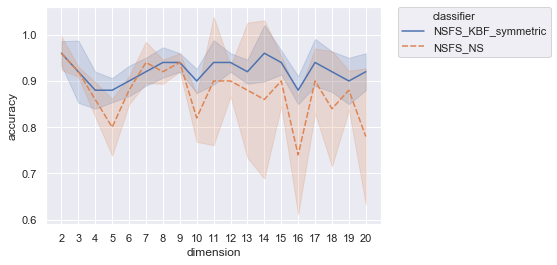

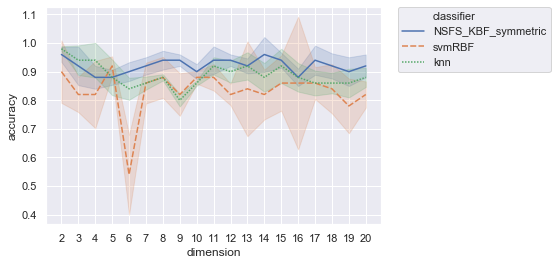

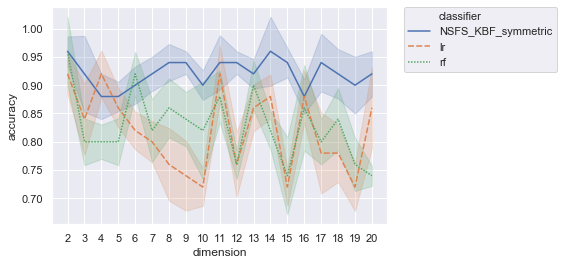

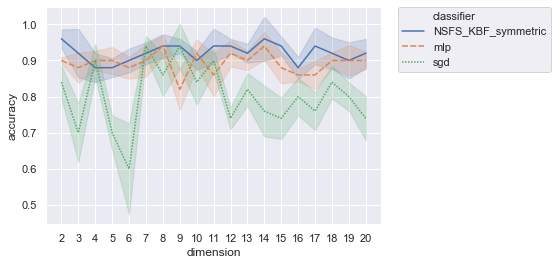

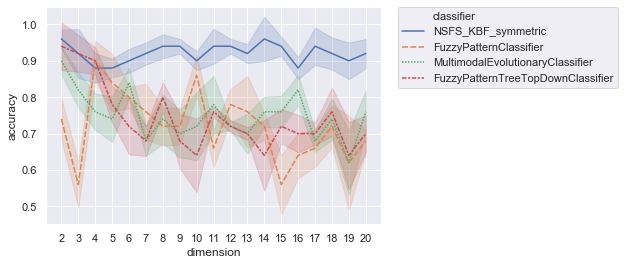

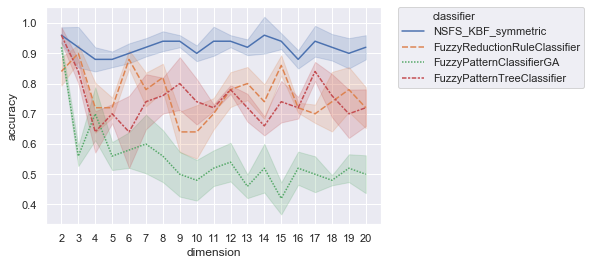

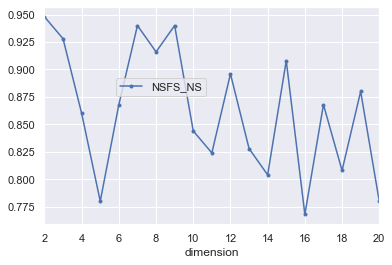

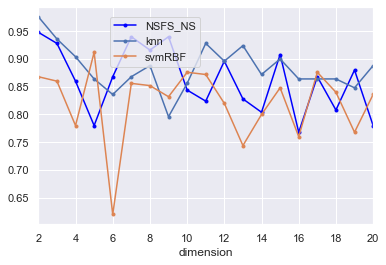

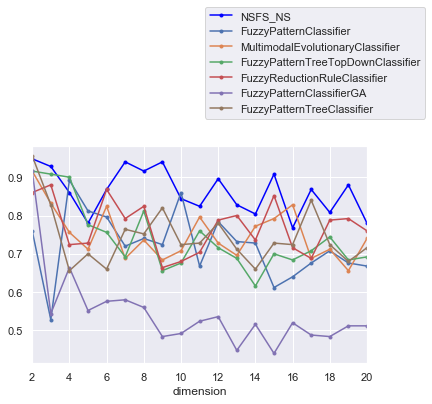

In [22]:
#PLOTS NESTED CV
import os
from functools import reduce
import seaborn as sns

def plot_sns_pointplot(df,list_classifiers):
    df_plot= df[df.classifier.isin(list_classifiers)]
    sns.set(style="darkgrid")
    #sns.lineplot(x="dimension", y="accuracy",
    #             hue="classifier", hue_order=list_classifiers,
    #             style="classifier",style_order=list_classifiers,
    #             data=df_plot)
    sns.pointplot(x="dimension", y="accuracy", data=df_plot,
                 hue="classifier", hue_order=list_classifiers,
                 style="classifier",style_order=list_classifiers)
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def plot_sns(df,list_classifiers):
    df_plot= df[df.classifier.isin(list_classifiers)]
    sns.set(style="darkgrid")
    #g=sns.lineplot(x="dimension", y="accuracy",
    #             hue="classifier", hue_order=list_classifiers,
    #             style="classifier",style_order=list_classifiers,
    #             data=df_plot)
    g=sns.lineplot(x="dimension", y="accuracy", hue="classifier",hue_order=list_classifiers,
                   style="classifier",style_order=list_classifiers,
                   err_style="band", 
                   ci='sd', 
                   estimator="median", 
                   data=df_plot)
    g.set_xticks(range(2, 21, 1))
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()    

#reading all the results starting with 'results'
list_classifiers=['NSFS_NS','NSFS_KBF_symmetric','svmRBF','knn',
                     'FuzzyPatternClassifier','MultimodalEvolutionaryClassifier',
                     'FuzzyPatternTreeTopDownClassifier','FuzzyReductionRuleClassifier',
                     'FuzzyPatternClassifierGA','FuzzyPatternTreeClassifier','lr','rf','mlp','sgd']

#path = '../experiments/data_dimension/non_nested_CV'
path = '../experiments/data_dimension/nestedCV'
#joining files
files = [filename for filename in os.listdir(path) if filename.startswith("results")]
l_df= [pd.read_csv(path+'/'+file,index_col=0)  for file in files]
df_results_non_nested = reduce(lambda left,right: pd.merge(left,right,on=['dimension','trial'],left_index=True), l_df)

#melt
df = df_results_non_nested.copy()
df = pd.melt(df, id_vars=['trial','dimension'], value_vars=list_classifiers,
             var_name='classifier', value_name='accuracy')
df = df.sort_values(by='dimension')
    
#ploting NSFS classifiers vs classical classifiers I
#-------------------------------------------------
#plt.figure(figsize=(20, 10))

plot_sns(df,['NSFS_KBF_symmetric','NSFS_NS'])
plot_sns(df,['NSFS_KBF_symmetric','svmRBF','knn'])
plot_sns(df,['NSFS_KBF_symmetric','lr','rf'])
plot_sns(df,['NSFS_KBF_symmetric','mlp','sgd'])
plot_sns(df,['NSFS_KBF_symmetric','FuzzyPatternClassifier',
             'MultimodalEvolutionaryClassifier','FuzzyPatternTreeTopDownClassifier'])
plot_sns(df,['NSFS_KBF_symmetric','FuzzyReductionRuleClassifier',
             'FuzzyPatternClassifierGA','FuzzyPatternTreeClassifier'])




######################################################
df_results=df_results_non_nested.groupby(['dimension']).mean().copy()
df_results.reset_index(level=0, inplace=True)
ax = plt.gca()

#df_results.plot(kind='line',x='dimension',y='NSFS_KBF', style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='NSFS_NS',  style='.-', ax=ax)
#df_results.plot(kind='line',x='dimension',y='NSFS_KBF_symmetric',color='blue',style='.-', ax=ax)
ax.legend(bbox_to_anchor=(0.5, 0.7))
plt.show()

#######

ax = plt.gca()

df_results.plot(kind='line',x='dimension',y='NSFS_NS', color='blue', style='.-',ax=ax)
df_results.plot(kind='line',x='dimension',y='knn', style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='svmRBF',  style='.-',ax=ax)
ax.legend(bbox_to_anchor=(0.5, 0.7))

plt.show()

#######

ax = plt.gca()

df_results.plot(kind='line',x='dimension',y='NSFS_NS', color='blue',style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='FuzzyPatternClassifier', style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='MultimodalEvolutionaryClassifier', style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='FuzzyPatternTreeTopDownClassifier', style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='FuzzyReductionRuleClassifier', style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='FuzzyPatternClassifierGA', style='.-', ax=ax)
df_results.plot(kind='line',x='dimension',y='FuzzyPatternTreeClassifier', style='.-', ax=ax)
ax.legend(bbox_to_anchor=(0.5, 1.1))

plt.show()
